<div style="border:solid Blue 2px; padding: 40px">
<h1> Проект для интернет-магазина</h1>

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. Имеется набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 


<div style="border:solid Green 2px; padding: 40px">
<h1> Описание данных</h1>

- Данные находятся в файле `toxic_comments.csv`. 
- ***text*** - содержит текст комментария
- ***toxic*** — целевой признак

In [1]:
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from numpy.random import RandomState
RANDOM_STATE = 1234

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

## Подготовка

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv', encoding='UTF-8')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.shape

(159292, 3)

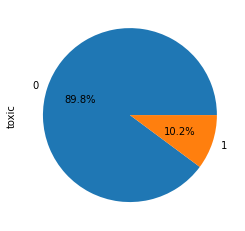

In [6]:
data['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%');

<div style="border:solid Blue 2px; padding: 40px">
    
    
- Загрузили данные
- Токсичных комментариев 10% от общего кол-ва комментариев.

### Подготовка текста

In [7]:
data['text'].head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

<div style="border:solid Blue 2px; padding: 40px">    
    Приводим к нижнему регистру и убираем лижние пробелы, элементы

In [8]:
m = Mystem()

def prepare_text(text):    
    text = text.lower()
    c_text = re.sub(r'[^a-zA-Z]', ' ', text) 
    return " ".join(c_text.split())

In [9]:
data['text'] = data['text'].apply(prepare_text)

In [10]:
data['text'].head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

<div style="border:solid Blue 2px; padding: 40px">
    
    Далее разбиваем на токены и лемматизируем:
        - Токенизация (tokenization) — разбиение текста на токены: слова, фразы или символы
        - Лемматизация (lemmatization) — приведение слова к начальной форме (лемме)

In [11]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return " ".join(x)

In [12]:
data['lemm_text'] = data['text'].apply(prepare_text)
data['lemm_text'] = data['lemm_text'].apply(lemmatize_text)

In [13]:
data['lemm_text'].head()

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
Name: lemm_text, dtype: object

## Обучение

<div style="border:solid Blue 2px; padding: 40px">
    
- Добавим стоп-слова (на английском языке) - т.к все комментарии на англ не используем приведение к юникоду
- Воспользуемся векторайзером TfidfVectorizer

In [14]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

<div style="border:solid Blue 2px; padding: 40px">
    
    Разделим на тренировочную и тестовую выборки

In [16]:
X = data.drop('toxic', axis=1)
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119469, 3)
(39823, 3)
(119469,)
(39823,)


<div style="border:solid Blue 2px; padding: 40px">
    
    Перезапишем выборки - тренировочную обучим и трансформируем, тестовую только трансформируем(!)

In [18]:
corpus_train = X_train['lemm_text']
corpus_test = X_test['lemm_text']

In [19]:
# убрала приведение к типу

In [20]:
X_train = count_tf_idf.fit_transform(corpus_train)
X_test = count_tf_idf.transform(corpus_test)

In [21]:
X_train.shape

(119469, 133654)

In [22]:
X_test.shape

(39823, 133654)

### LogisticRegression

In [23]:
%%time

model_LR = LogisticRegression (random_state=RANDOM_STATE, class_weight='balanced')
params = {
    'solver':['liblinear']
}
gs = GridSearchCV(model_LR, 
                  params, 
                  cv=5, 
                  scoring='f1', 
                  verbose=False).fit(X_train, y_train)

F1_score_LR = gs.best_score_
print(F1_score_LR)
print(gs.best_params_)

0.7483247286398665
{'solver': 'liblinear'}
CPU times: user 35.9 s, sys: 35.3 s, total: 1min 11s
Wall time: 1min 11s


### DecisionTreeClassifier

In [24]:
%%time

model_DT = DecisionTreeClassifier(random_state=RANDOM_STATE)
params = {
   'criterion':['gini', 'entropy'],        
   'max_depth':[3, 12, 3]
}
gs_dt = GridSearchCV(model_DT, 
                     params, 
                     cv=5, 
                     scoring='f1', 
                     verbose=False).fit(X_train, y_train)

F1_score_DT = gs_dt.best_score_
print (F1_score_DT)
print(gs_dt.best_params_)

0.6069448864566079
{'criterion': 'gini', 'max_depth': 12}
CPU times: user 7min 18s, sys: 377 ms, total: 7min 19s
Wall time: 7min 20s


<div style="border:solid Blue 2px; padding: 40px">     
     
- Лучшая модель LogisticRegression с метрикой F1 score равной 74.6
- Далее тестируем на выборке и посмотрим итоговый F1

## Тестирование лучшей модели

In [25]:
model_test = gs.best_estimator_
model_test.fit(X_train, y_train)
predictions = model_test.predict(X_test)
print('TEST LogisticRegression: ', f1_score(predictions, y_test))

TEST LogisticRegression:  0.7521591778725266


## Выводы

<div style="border:solid Blue 2px; padding: 40px">

<h3><b>Итоговый комментарий</b></h3> 

- Проведена предобработка данных и загрузка необходимых библиотек
- Обучили две модели LinearRegressor и DecisionTreeClassifier
- F1 итоговой модели LinearRegressor на тестовой выборке 0.75 (что и требовалось)

    Время обучения и предсказания LinearRegressor: 67 s